# Sentiment Analysis on Twiter data on Stocks

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import json, nltk
import re

from helper import plot_history
data_dir = '../data/'

In [2]:
def load_data():
    with open(data_dir+'pr_06_twits.json', 'r') as f:
        twits = json.load(f)
    df = pd.DataFrame(twits['data'])
    return df
    
data = load_data()

In [3]:
print (f"data shape:{data.shape}")
data.head(2)

data shape:(1548010, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,2,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,1,2018-07-01T00:00:42Z


In [4]:
# cut the data short to make learning faster keep only 8010 of them
#random_indices = np.random.choice(range(df.shape[0]), size=8010)
#df = df.loc[random_indices]
df = data.loc[:10000]

In [5]:
df.sentiment.unique()

array([ 2,  1,  0, -2, -1])

In [6]:
# convert the labels from -2 to 2 to 0 to 4
df['sentiment'] = df['sentiment']+2
df.sentiment.unique()

<ipython-input-6-b0dffd00bd87>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment']+2


array([4, 3, 2, 0, 1])

In [7]:
print (f" new data shape:{df.shape}")
df.head(2)

 new data shape:(10001, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z


In [9]:
def Print_random_tweets(df):
    for i in range(5):
        print (f"Tweets with sentiment {i+1}" )
        for i in range(3):            
            twt1 = df[df['sentiment']==i].sample(1)['message_body'].values[0]
            print (twt1)
            print ()
        print ("===================")
        print ()

        
Print_random_tweets(df)

Tweets with sentiment 1
$AMD here comes the crash

$NFLX love that spread action as soon as it hits 390 lol

Compared to an average industry PE Ratio of 17.19, $JPM is valued rather cheaply. https://www.chartmill.com/analyze.php?utm_source=stocktwits&amp;utm_medium=FA&amp;utm_content=VALUATION&amp;utm_campaign=social_tracking#/JPM?r=fa&amp;key=e6dcd9f6-799c-4c85-8072-8a229a321bd0


Tweets with sentiment 2
$MNK Cup-and-Holder Inverse (bearish) with 48.20% CONFIDENCE TO REACH TARGET PRICE 16.16USD

$SPY wow @ the spike in $VIX sell while u can folks enjoy your holiday sheesh. $QQQ $AAPL

$NVDA Sellers exhausted here, forming a reversal on the monthly. A prime swing set-up. $SPY $QQQ


Tweets with sentiment 3
Recent $BKNG technical alerts: 180 Bearish Setup plus 7 more alerts... https://swingtradebot.com/equities/BKNG

According to data reported to FINRA, short volume percent for $WYNN clocked in at 34.91% on 06-28-18 https://volumebot.com/?s=WYNN

$AAPL we had Bush f us up, now we got Do

In [10]:
def preprocess(message):    
    text = message.lower()                   # Lowercase the twit message
    text = re.sub(r'https?://\S+', ' ', text)# Replace URLs with a space
    text = re.sub(r'\$\S+', ' ', text)       # Replace ticker symbols with a space
    text = re.sub(r'\@\S+', ' ', text)       # Replace StockTwits usernames with a space.
    text = re.sub(r'[^a-zA-Z]', ' ', text)   # Replace everything not a letter with a space
    
    # Tokenize
    tokens = nltk.tokenize.word_tokenize(text)

    # Lemmatize words using the WordNetLemmatizer. You can ignore any word that is not longer than one character.
    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [wnl.lemmatize(token) for token in tokens if len(token) > 1]
    
    return tokens

df['message_tokenized'] = df["message_body"].apply(preprocess)

<ipython-input-10-1999f57a38e0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['message_tokenized'] = df["message_body"].apply(preprocess)


In [11]:
df.head(2)

,message_body,sentiment,timestamp,message_tokenized
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]"
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z,[]


In [12]:
from collections import Counter

"""
Create a vocabulary by using Bag of words
"""
tokenized_words = [word for twit in df.message_tokenized for word in twit]
bow = Counter(tokenized_words)

In [14]:
bow.most_common(15)

[('the', 2590),
 ('to', 2458),
 ('is', 2191),
 ('for', 1966),
 ('on', 1760),
 ('of', 1522),
 ('in', 1418),
 ('and', 1297),
 ('this', 1268),
 ('it', 1113),
 ('will', 833),
 ('are', 797),
 ('at', 775),
 ('short', 760),
 ('up', 718)]

In [15]:
def remove_words(bow, low_cutoff=1e-5, high_cutoff=10):
    # remove the words which are outside the cutoff range
    # they usually are too common or too rare to make any big impact on the analysis
    total_cnt = sum(bow.values())
    
    freqs = dict(bow)
    for key in freqs:
        freqs[key] = freqs[key]/total_cnt
        
    K_most_common = [word[0] for word in bow.most_common(high_cutoff)]
    
    filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
    
    return freqs, filtered_words


In [16]:
freqs, filtered_words= remove_words(bow)

In [17]:
def prepare_vocab_dict(filtered_words):
    # A dictionary for the `filtered_words`.
    vocab = {word:idx+1 for idx, word in enumerate(filtered_words)}
    # reverse the vocab dictionary
    id2vocab = {idx:word for word, idx in vocab.items()}
    return vocab, id2vocab

vocab, id2vocab = prepare_vocab_dict(filtered_words)

In [18]:
print ("Top 5 word to index items")
for item in list(vocab.items())[:5]:
    print (item)
    
print ("\nTop 5 index to words items")
for item in list(id2vocab.items())[:5]:
    print (item)


Top 5 word to index items
('great', 1)
('buy', 2)
('at', 3)
('ill', 4)
('wait', 5)

Top 5 index to words items
(1, 'great')
(2, 'buy')
(3, 'at')
(4, 'ill')
(5, 'wait')


In [19]:
def filter_twit(words, filtered_words):
     return [word for word in words if word in filtered_words]

tmp = df['message_tokenized'].values[50]
print (tmp)
filter_twit(tmp, filtered_words)

['how', 'expect', 'the', 'earnings']


['how', 'expect', 'earnings']

In [20]:
df['filtered'] = df['message_tokenized'].apply(filter_twit, filtered_words=filtered_words)

<ipython-input-20-987fad6bb275>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filtered'] = df['message_tokenized'].apply(filter_twit, filtered_words=filtered_words)


In [22]:
df.head(5)

,message_body,sentiment,timestamp,message_tokenized,filtered
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]","[great, buy, at, ill, wait]"
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z,[],[]
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,"[staanalystalert, for, jefferies, maintains, w...","[staanalystalert, jefferies, maintains, with, ..."
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z,"[heard, there, guy, who, know, someone, who, t...","[heard, there, guy, who, know, someone, who, t..."
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z,"[reveal, yourself]","[reveal, yourself]"


### Balancing the classes

In [23]:
print ( df.sentiment.unique() )

[4 3 2 0 1]


In [24]:
def find_counts(df):
    df_counts =df.groupby("sentiment", axis=0).count()
    df_counts["ratio (pct)"] = 100*df_counts["message_body"]/sum(df_counts["message_body"])
    return df_counts

find_counts(df)

,message_body,timestamp,message_tokenized,filtered,ratio (pct)
sentiment,,,,,
0,902,902,902,902,9.019098
1,1127,1127,1127,1127,11.268873
2,4799,4799,4799,4799,47.985201
3,1806,1806,1806,1806,18.058194
4,1367,1367,1367,1367,13.668633


this means almost half of the tweets are neutral in the sentiment. a classic example of unbalanced data set. One way to treat this is to remove the neutral data so that the class becomes more or less neutral. Here we'll make the counts of sentiment 2 and sentiment 3 equal.

In [25]:
def balance_classes(df):
    delete_after = df[df['sentiment']==3].shape[0] 
    indices_to_delete = df[df['sentiment']==2].index.values[delete_after:]
    #indices_to_delete = np.random.choice(df[df['sentiment']==2].index.values,
    #                                     len(df[df['sentiment']==2].index.values)-val)
    df = df.drop(index=indices_to_delete, axis=0)
    return df
    
df = balance_classes(df)

In [26]:
find_counts(df)

,message_body,timestamp,message_tokenized,filtered,ratio (pct)
sentiment,,,,,
0,902,902,902,902,12.871005
1,1127,1127,1127,1127,16.081621
2,1806,1806,1806,1806,25.770548
3,1806,1806,1806,1806,25.770548
4,1367,1367,1367,1367,19.506279


In [27]:
# delete texts with zero length
df['counts'] = df.filtered.apply(len)
df.head()

,message_body,sentiment,timestamp,message_tokenized,filtered,counts
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]","[great, buy, at, ill, wait]",5
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z,[],[],0
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,"[staanalystalert, for, jefferies, maintains, w...","[staanalystalert, jefferies, maintains, with, ...",15
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z,"[heard, there, guy, who, know, someone, who, t...","[heard, there, guy, who, know, someone, who, t...",12
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z,"[reveal, yourself]","[reveal, yourself]",2


In [28]:
df = df[df['counts']>0]
df.head()

,message_body,sentiment,timestamp,message_tokenized,filtered,counts
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]","[great, buy, at, ill, wait]",5
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,"[staanalystalert, for, jefferies, maintains, w...","[staanalystalert, jefferies, maintains, with, ...",15
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z,"[heard, there, guy, who, know, someone, who, t...","[heard, there, guy, who, know, someone, who, t...",12
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z,"[reveal, yourself]","[reveal, yourself]",2
5,$AAPL Why the drop? I warren Buffet taking out...,3,2018-07-01T00:03:10Z,"[why, the, drop, warren, buffet, taking, out, ...","[why, drop, warren, buffet, taking, out, his, ...",8


In [29]:
find_counts(df)

,message_body,timestamp,message_tokenized,filtered,counts,ratio (pct)
sentiment,,,,,,
0,894,894,894,894,894,13.209220
1,1112,1112,1112,1112,1112,16.430260
2,1676,1676,1676,1676,1676,24.763593
3,1729,1729,1729,1729,1729,25.546690
4,1357,1357,1357,1357,1357,20.050236


## Prepare input for Model
- convert the text entry to numerical values
- Pad the numerical values to a certain length
- convert the y labels to categorical 
- train, test, val split

In [30]:
df.head(2)

,message_body,sentiment,timestamp,message_tokenized,filtered,counts
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]","[great, buy, at, ill, wait]",5
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,"[staanalystalert, for, jefferies, maintains, w...","[staanalystalert, jefferies, maintains, with, ...",15


In [31]:
df.counts.max()

24

In [32]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

MAX_SEQUENCE_LEN = 20

def text_to_numerics(text, vocab):
    return [vocab[word] for word in text]

def pad_list(lst, max_len):
    # pad a list with zeros at the end to make the length max_len
    lst = lst+[0]*(max_len-len(lst))
    return lst[:max_len]
    
def prepare_input_for_model(df, MAX_SEQUENCE_LEN=20):
    df['text_to_number'] = df['filtered'].apply(text_to_numerics, vocab=vocab)
    df["padded_x"] = df['text_to_number'].apply(pad_list, max_len=MAX_SEQUENCE_LEN)

    X = np.array(df["padded_x"].values)
    X = np.stack( X, axis=0 )
    
    y = df['sentiment'].values
    y = to_categorical(y)
    return (df, X, y)
    
def split_data(X, y):
    X_train_, X_val, y_train_, y_val = train_test_split(X, y, test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X_train_, y_train_, test_size=0.25)

    print (f"X_train.shape: {X_train.shape} y_train.shape:{y_train.shape}" )
    print (f"X_test.shape: {X_test.shape} y_test.shape:{y_test.shape}" )
    print (f"X_val.shape: {X_val.shape} y_val.shape:{y_val.shape}" )

    return X_train, X_test, X_val, y_train, y_test, y_val

(df, X, y) = prepare_input_for_model(df, MAX_SEQUENCE_LEN=MAX_SEQUENCE_LEN)
X_train, X_test, X_val, y_train, y_test, y_val =  split_data(X, y)


X_train.shape: (4060, 20) y_train.shape:(4060, 5)
X_test.shape: (1354, 20) y_test.shape:(1354, 5)
X_val.shape: (1354, 20) y_val.shape:(1354, 5)


In [33]:
df.sentiment.unique()

array([4, 3, 2, 0, 1])

## Model Training

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import preprocessing
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [58]:
def make_model(X, y, vocab=vocab, embedding_length = 20):
    model = Sequential()
    model.add(Embedding(len(vocab.items())+1, embedding_length, input_length=X.shape[1]))
    
    # model-1
    #model.add(LSTM(6, bias_regularizer="l2", return_sequences=True))  # , dropout=.1
    #model.add(LSTM(6, bias_regularizer="l2")) #, dropout=.1
    
    # model-2
    #model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(LSTM(6, activation='tanh', bias_regularizer="l2",  return_sequences=True))
    model.add(LSTM(16, activation='tanh', bias_regularizer="l2")) #, dropout=.1

    #model.add(Dropout(0.2))
    model.add(Dense(y.shape[1], activation='softmax'))
    opt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = make_model(X_train, y_train)
history = model.fit(X_train, y_train, epochs=15, verbose=1, batch_size=16,
                      validation_data=(X_val, y_val))

Epoch 1/15
254/254 [==============================] - 3s 12ms/step - loss: 1.6791 - accuracy: 0.2791 - val_loss: 1.5384 - val_accuracy: 0.3375
Epoch 2/15
254/254 [==============================] - 2s 8ms/step - loss: 1.3550 - accuracy: 0.4618 - val_loss: 1.3375 - val_accuracy: 0.4793
Epoch 3/15
254/254 [==============================] - 2s 7ms/step - loss: 1.0833 - accuracy: 0.6017 - val_loss: 1.2409 - val_accuracy: 0.5295
Epoch 4/15
254/254 [==============================] - 2s 7ms/step - loss: 0.9237 - accuracy: 0.6591 - val_loss: 1.2544 - val_accuracy: 0.5044
Epoch 5/15
254/254 [==============================] - 2s 7ms/step - loss: 0.8002 - accuracy: 0.7037 - val_loss: 1.3064 - val_accuracy: 0.5325
Epoch 6/15
254/254 [==============================] - 2s 7ms/step - loss: 0.7142 - accuracy: 0.7429 - val_loss: 1.3120 - val_accuracy: 0.5369
Epoch 7/15
254/254 [==============================] - 2s 8ms/step - loss: 0.6485 - accuracy: 0.7677 - val_loss: 1.2997 - val_accuracy: 0.5473
Epoch

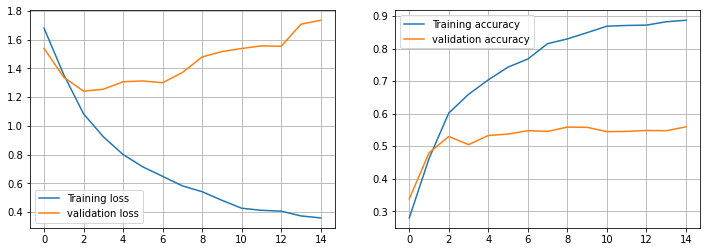

In [59]:
plot_history(history1)

In [70]:
from sklearn.metrics import confusion_matrix

In [71]:
ypred = model.predict(X_test)

In [72]:
np.argmax(y_test,axis=1)

array([1, 3, 2, ..., 1, 2, 4])

In [73]:
confusionmatrix=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(ypred,axis=1))

In [74]:
confusionmatrix

array([[ 78,  20,  14,  27,  16],
       [ 36,  93,  34,  38,  17],
       [  5,  17, 206,  85,  24],
       [ 25,  22,  51, 210,  57],
       [  3,   9,  27,  87, 153]])

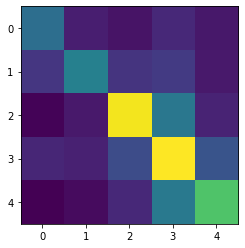

In [75]:
plt.imshow(confusionmatrix)

In [ ]:
# save model and other important things
model.save('model_multiclass')

In [ ]:
import json
with open('vocab.json', 'w') as fp:
    json.dump(vocab, fp)

In [ ]:
import json
with open('words.json', 'w') as fp:
    json.dump(filtered_words, fp)

In [ ]:
# loading the saved model, vocab, filtered_words
from tensorflow import keras
model = keras.models.load_model('./model_multiclass')

In [ ]:
with open('vocab.json', 'r') as fp:
    vocab = json.load(fp)
    
with open('words.json', 'r') as fp:
    filtered_words = json.load(fp)


## Predictions

In [79]:
def Prediction(text, model=model, vocab=vocab, filtered_words=filtered_words):
    # prepare the input text
    #text = "Google is working on self driving cars, I'm bullish on $goog"
    tokens = preprocess(text)
    tokens = [word for word in tokens if word in filtered_words]
    tokens = [vocab[word] for word in tokens] 
    X_input = np.array(pad_list(tokens, 20)).reshape(1,-1)
    
    y_out = model.predict(X_input)
    sentiment = np.argmax(y_out,axis=1)[0]+1 # to make it 1 to 5
    
    print (f"The following Tweet\n\n {text} \n\n\
    has a number {sentiment} sentiment on a scale of 1 to 5")


In [80]:
#text = "Google is working on self driving cars, I'm bullish on $goog"
text = " $AAPL had a big increase. I am really happy for this."
#text = " Sad to see the stocks going down."

Prediction(text)

The following Tweet

  $AAPL had a big increase. I am really happy for this 

    has a number 4 sentiment on a scale of 1 to 5
